In [1]:
from sklearn import model_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import KFold 

from tqdm.auto import tqdm


c:\Users\ADMIN PC\Documents\Zoomcamp\ML engineering\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read data into daatframe
df = pd.read_csv('C:/Users/ADMIN PC/Documents/Zoomcamp/ML engineering/Churn Prediction model/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.replace(' ', '_').str.lower()

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = df.churn.apply(lambda x: 0 if x == 'No' else 1).astype(int)

In [3]:
df.churn.value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'totalcharges', 'monthlycharges']

categorical = [col for col in df.columns if col not in numerical and col not in ['customerid', 'churn']]


In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\ADMIN PC\Documents\Zoomcamp\ML engineering\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
len(X_train[:1][0])

45

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, -1]
churn_decision = (y_pred >=0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

### Accuracy 

In [9]:
# Trying different threshold for the sigmoid function

thresholds = np.linspace(0, 1, 15)
scores = []

for thresh in thresholds:
    churn_decision = (y_pred >=thresh)
    score = (y_val == churn_decision).mean()
    scores.append(score)
    print(f'{round(thresh, 2)}, {round(score, 3)}')

0.0, 0.274
0.07, 0.538
0.14, 0.659
0.21, 0.722
0.29, 0.757
0.36, 0.772
0.43, 0.79
0.5, 0.803
0.57, 0.804
0.64, 0.786
0.71, 0.761
0.79, 0.736
0.86, 0.726
0.93, 0.726
1.0, 0.726


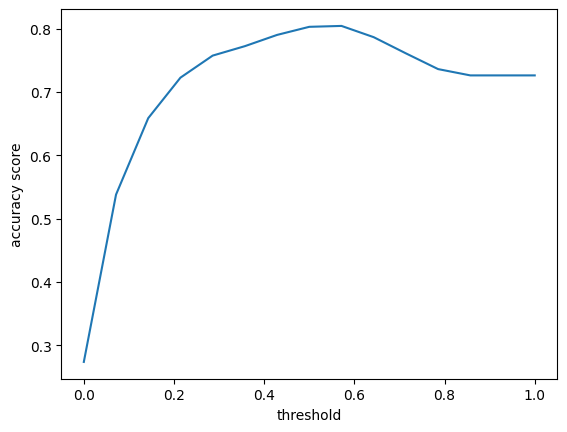

In [10]:
# Visualizing the threshold and their corresponding accurracy scores
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('accuracy score');

The above plot shows that when the threshold is at `1`, the model has a high accuracy score of `0.726`, this is due to class imbalance and it is the reson why `accuracy` is not the best metric for evaluating classification models where there is a class imbalance.


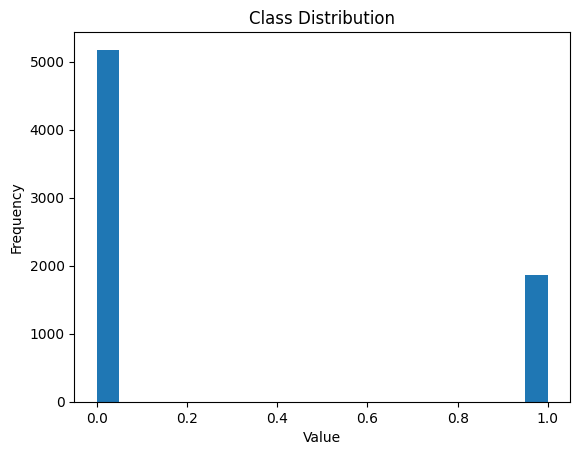

In [11]:
plt.hist(df['churn'], bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Class Distribution');

### Confusion Matrix

In [12]:
choosen_threshold = 0.5

predicted_positive = (y_pred >= choosen_threshold)
predicted_negative = (y_pred < choosen_threshold)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


In [13]:
tp = (predicted_positive & actual_positive).sum()
fn = (predicted_negative & actual_positive).sum()

tn = (predicted_negative & actual_negative).sum()
fp = (predicted_positive & actual_negative).sum()

conf_matrix = np.array([[tn, fp], [fn, tp]])
conf_matrix

array([[921, 102],
       [176, 210]])

In [14]:
(conf_matrix/conf_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

### Precision and Recall


Precision is the fraction of the model's predictions of the positive class that are acually posiitive(correct).

while 

Recall is the fraction of the actual positives that are correctly identified by the model.

In [15]:
precision = tp / (tp + fp)
precision

np.float64(0.6730769230769231)

In [16]:
recall = tp / (tp + fn)
recall

np.float64(0.5440414507772021)

### ROC Curves


#### True Positive Rate and False Positive Rate

In [17]:
tpr = tp/ (tp + fn)
tpr

np.float64(0.5440414507772021)

In [18]:
fpr = fp/(fp + tn)
fpr

np.float64(0.09970674486803519)

In [19]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

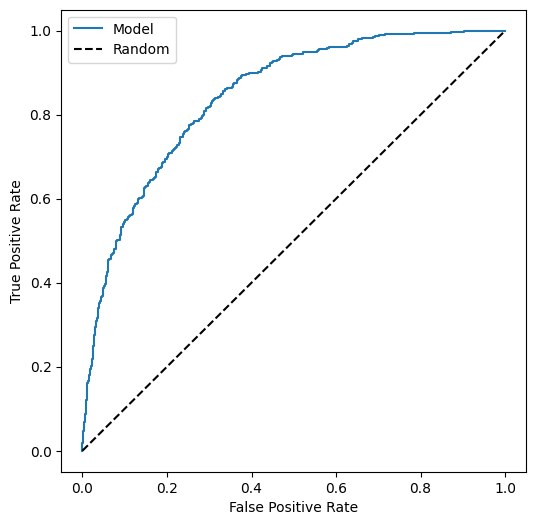

In [20]:
plt.figure(figsize=(6, 6))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

### ROC AUC

- Area under the ROC curve 


AUC give the probability that a randomly selected positive example has a score higher than a randomly selected negative example.

In [21]:
roc_auc_score(y_val, y_pred)

np.float64(0.8438403760148703)

In [22]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]


n = 10000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8412)

### Cross-validation 

In [23]:
def train_model(df_train, y_train, C=0.001):
    dv = DictVectorizer(sparse=False)
    training_dict = df_train[categorical + numerical].to_dict(orient='records')

    X_train_encoded = dv.fit_transform(training_dict)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train_encoded, y_train)

    return dv, model

In [25]:
dv, model = train_model(df_train, y_train)

In [26]:
def generate_predictions(df, dv, model):
    X_test = dv.transform(df[categorical + numerical].to_dict(orient='records'))

    y_pred = model.predict_proba(X_test)[:, -1]

    return y_pred


In [27]:
y_pred = generate_predictions(df_val, dv, model)


In [28]:
n = 10
best_score = (0, 0)
for C in tqdm([0.0001, 0.001, 0.1, 0.5, 1, 5, 10]):

    scores = []
    kf = KFold(n_splits=n, shuffle=True, random_state=1)


    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train_model(df_train, y_train, C=C)
        y_pred = generate_predictions(df_val, dv, model)

        score = roc_auc_score(y_val, y_pred)
        scores.append(score)
    
    print('For C= %s, mean AUC = %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))
    if np.mean(scores) >= best_score[1]:
        best_score = (C, np.mean(scores))
print(f'The C with the best score is {best_score[0]}, and the best score is {best_score[1]}')


 14%|█▍        | 1/7 [00:02<00:16,  2.77s/it]

For C= 0.0001, mean AUC = 0.8110 +- 0.0119


 29%|██▊       | 2/7 [00:07<00:18,  3.66s/it]

For C= 0.001, mean AUC = 0.8261 +- 0.0118


 43%|████▎     | 3/7 [00:28<00:46, 11.64s/it]

For C= 0.1, mean AUC = 0.8424 +- 0.0117


 57%|█████▋    | 4/7 [00:40<00:35, 11.73s/it]

For C= 0.5, mean AUC = 0.8426 +- 0.0117


 71%|███████▏  | 5/7 [00:53<00:24, 12.25s/it]

For C= 1, mean AUC = 0.8425 +- 0.0117


 86%|████████▌ | 6/7 [01:07<00:12, 12.78s/it]

For C= 5, mean AUC = 0.8424 +- 0.0116


100%|██████████| 7/7 [01:22<00:00, 11.82s/it]

For C= 10, mean AUC = 0.8423 +- 0.0116
The C with the best score is 0.5, and the best score is 0.842573142977994


### Final Model

From the cross validation above, it is obvious that the C with the besr score is 0.5, I'll use that to train a mdoel on the full train set and test on the test set for the score.

In [29]:
final_C = 0.5
y_train_final = df_full_train.churn.values 

final_dv, final_model = train_model(df_full_train, y_train_final, final_C)
final_y_pred = generate_predictions(df_test, final_dv, final_model)

# Model Score 

final_score = roc_auc_score(y_test, final_y_pred)
print('Final Score: %.4f' % final_score)

Final Score: 0.8584


In general, `ROC AUC` is a solid choice for performance measurement, but for highly imbalanced datasets, supplementing it with `PR AUC` or oversampling techniques can give you a clearer picture of your model’s performance.